In [3]:
%pwd

'd:\\Projects\\GasHisClassifier\\Data'

In [4]:
import time
import math
import json
import os
import sys
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import tensorflow as tf

DATA_DIR = 'data'
TARGET_SIZE = (64, 64)
BATCH_SIZE = 256

# Data generators
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'valid'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Convert generators to tf.data.Dataset
def generator_to_tfdata(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, TARGET_SIZE[0], TARGET_SIZE[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(generator.class_indices)), dtype=tf.float32),
        )
    )
    return dataset

train_dataset = generator_to_tfdata(train_generator).repeat()
valid_dataset = generator_to_tfdata(valid_generator).repeat()

Found 13313 images belonging to 2 classes.
Found 13313 images belonging to 2 classes.
Found 6658 images belonging to 2 classes.


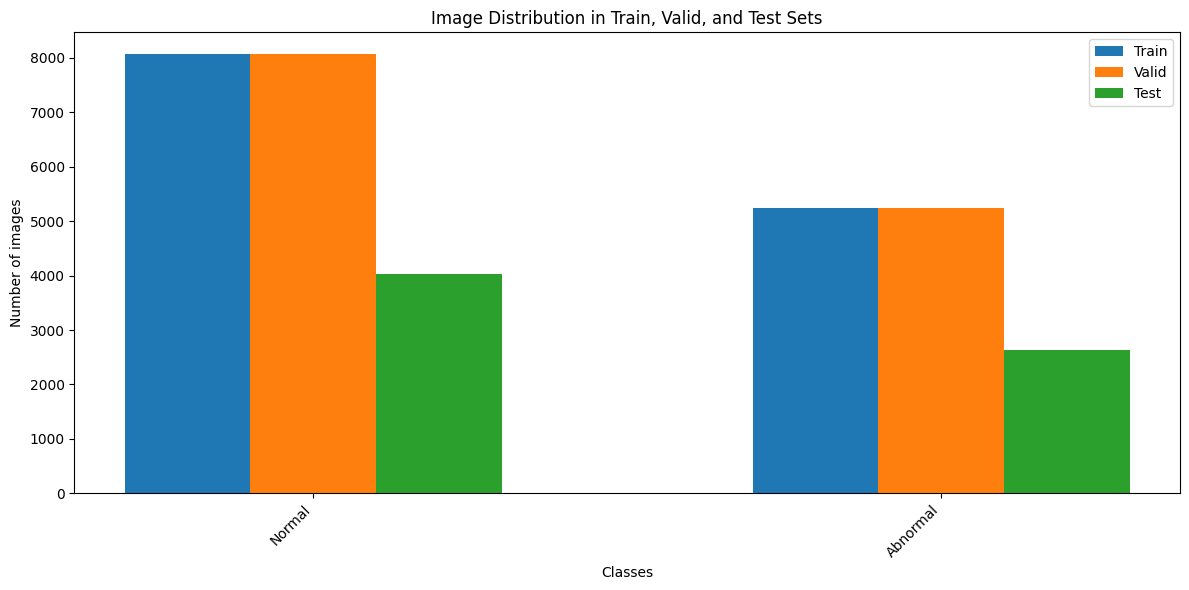

In [5]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Function to count images in each class
def count_images(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        if len(files) > 0:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)
    return class_counts

# Count images in train, valid, and test directories
train_counts = count_images(os.path.join(DATA_DIR, 'train'))
valid_counts = count_images(os.path.join(DATA_DIR, 'valid'))
test_counts = count_images(os.path.join(DATA_DIR, 'test'))

# Get all unique class names
all_classes = set(train_counts.keys()).union(valid_counts.keys()).union(test_counts.keys())

# Ensure all classes are in each count dictionary
train_counts = {cls: train_counts.get(cls, 0) for cls in all_classes}
valid_counts = {cls: valid_counts.get(cls, 0) for cls in all_classes}
test_counts = {cls: test_counts.get(cls, 0) for cls in all_classes}

# Create the grouped bar chart
def plot_grouped_counts(train_counts, valid_counts, test_counts):
    classes = list(all_classes)
    x = np.arange(len(classes))
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width, [train_counts[cls] for cls in classes], width, label='Train')
    bars2 = ax.bar(x, [valid_counts[cls] for cls in classes], width, label='Valid')
    bars3 = ax.bar(x + width, [test_counts[cls] for cls in classes], width, label='Test')

    # Add some text for labels, title, and axes ticks
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of images')
    ax.set_title('Image Distribution in Train, Valid, and Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

plot_grouped_counts(train_counts, valid_counts, test_counts)


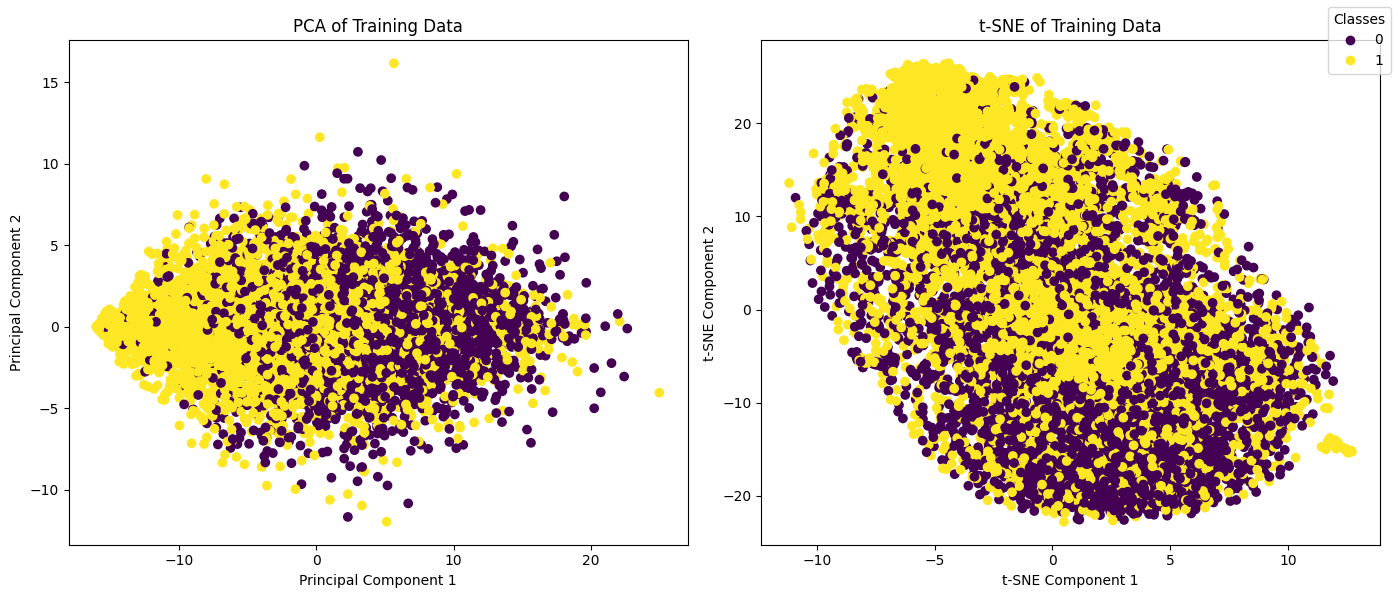

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_features(generator, num_samples):
    features = []
    labels = []
    i = 0
    for batch, label in generator:
        features.append(batch)
        labels.append(label)
        i += batch.shape[0]
        if i >= num_samples:
            break
    features = np.concatenate(features)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]
    return features, labels

num_samples = 13313  # Adjust this based on your dataset size
train_features, train_labels = extract_features(train_generator, num_samples)

# Reshape features for PCA/t-SNE
flattened_features = train_features.reshape(num_samples, -1)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_features)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(flattened_features)

# Plotting PCA and t-SNE in one figure
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot PCA
scatter = ax[0].scatter(pca_result[:, 0], pca_result[:, 1], c=np.argmax(train_labels, axis=1), cmap='viridis')
ax[0].set_title('PCA of Training Data')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

# Plot t-SNE
scatter = ax[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=np.argmax(train_labels, axis=1), cmap='viridis')
ax[1].set_title('t-SNE of Training Data')
ax[1].set_xlabel('t-SNE Component 1')
ax[1].set_ylabel('t-SNE Component 2')

# Add a single legend for both plots
handles, labels = scatter.legend_elements()
fig.legend(handles, np.unique(np.argmax(train_labels, axis=1)), title="Classes", loc="upper right")

plt.tight_layout()
plt.show()


In [11]:
# Tỷ lệ phương sai được giữ lại. Đánh giá sự mất mát thông tin của PCA
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance by PCA: {explained_variance:.4f}")
# Với tSNE thì không có phương pháp đánh giá sự mất mát thông tin của việc giảm chiều

Explained Variance by PCA: 0.2284


In [7]:
import pickle

# Save PCA model
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

# Save t-SNE model
with open('tsne_model.pkl', 'wb') as f:
    pickle.dump(tsne, f)

# # Load PCA and t-SNE models
# with open('pca_model.pkl', 'rb') as f:
#     pca = pickle.load(f)

# with open('tsne_model.pkl', 'rb') as f:
#     tsne = pickle.load(f)

# Save PCA and t-SNE results
with open('pca_result.pkl', 'wb') as f:
    pickle.dump(pca_result, f)

with open('tsne_result.pkl', 'wb') as f:
    pickle.dump(tsne_result, f)

# # Load PCA and t-SNE results
# with open('pca_result.pkl', 'rb') as f:
#     pca_result = pickle.load(f)

# with open('tsne_result.pkl', 'rb') as f:
#     tsne_result = pickle.load(f)

In [10]:
import numpy as np

def calculate_mean_std(features):
    mean_r = np.mean(features[:, :, :, 0])
    mean_g = np.mean(features[:, :, :, 1])
    mean_b = np.mean(features[:, :, :, 2])
    
    std_r = np.std(features[:, :, :, 0])
    std_g = np.std(features[:, :, :, 1])
    std_b = np.std(features[:, :, :, 2])
    
    mean = [mean_r, mean_g, mean_b]
    std = [std_r, std_g, std_b]
    
    return mean, std

mean, std = calculate_mean_std(train_features)

print("Mean of training set:", mean)
print("Std of training set:", std)

# Save mean and std to a file
with open('data_mean_std.pkl', 'wb') as f:
    pickle.dump({'mean': mean, 'std': std}, f)

# # Load mean and std from the file
# with open('data_mean_std.pkl', 'rb') as f:
#     data_stats = pickle.load(f)
#     mean = data_stats['mean']
#     std = data_stats['std']

Mean of training set: [0.9038076, 0.7860429, 0.9072475]
Std of training set: [0.12589078, 0.17736474, 0.09883375]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Các hàm hỗ trợ
def plot_clustering(ax, title, data, labels):
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
# KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(flattened_features)
# plot_clustering(axes[0, 0], 'KMeans Clustering', tsne_result, kmeans_labels)
kmeans_ari = adjusted_rand_score(np.argmax(train_labels, axis=1), kmeans_labels)
print(f"KMeans ARI: {kmeans_ari:.4f}")

KMeans ARI: 0.0647


In [16]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(flattened_features)
# plot_clustering(axes[0, 1], 'DBSCAN Clustering', tsne_result, dbscan_labels)
dbscan_ari = adjusted_rand_score(np.argmax(train_labels, axis=1), dbscan_labels)
print(f"DBSCAN ARI: {dbscan_ari:.4f}")

DBSCAN ARI: -0.0030


In [17]:
# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=2)
agg_labels = agg.fit_predict(flattened_features)
# plot_clustering(axes[0, 2], 'Agglomerative Clustering', tsne_result, agg_labels)
agg_ari = adjusted_rand_score(np.argmax(train_labels, axis=1), agg_labels)
print(f"Agglomerative Clustering ARI: {agg_ari:.4f}")

Agglomerative Clustering ARI: 0.0588


In [18]:
# Gaussian Mixture Models
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(flattened_features)
# plot_clustering(axes[1, 0], 'Gaussian Mixture Models Clustering', tsne_result, gmm_labels)
gmm_ari = adjusted_rand_score(np.argmax(train_labels, axis=1), gmm_labels)
print(f"Gaussian Mixture Models ARI: {gmm_ari:.4f}")

Gaussian Mixture Models ARI: 0.0647


In [ ]:
# Nhãn thực tế
# plot_clustering(axes[1, 1], 'Actual Labels', tsne_result, np.argmax(train_labels, axis=1))

# Tỷ lệ phương sai của PCA
# explained_variance = PCA(n_components=2).fit(flattened_features).explained_variance_ratio_.sum()
# axes[1, 2].text(0.1, 0.5, f"PCA Explained Variance: {explained_variance:.4f}", fontsize=12)
# axes[1, 2].set_xticks([])
# axes[1, 2].set_yticks([])

# plt.tight_layout()
# plt.show()

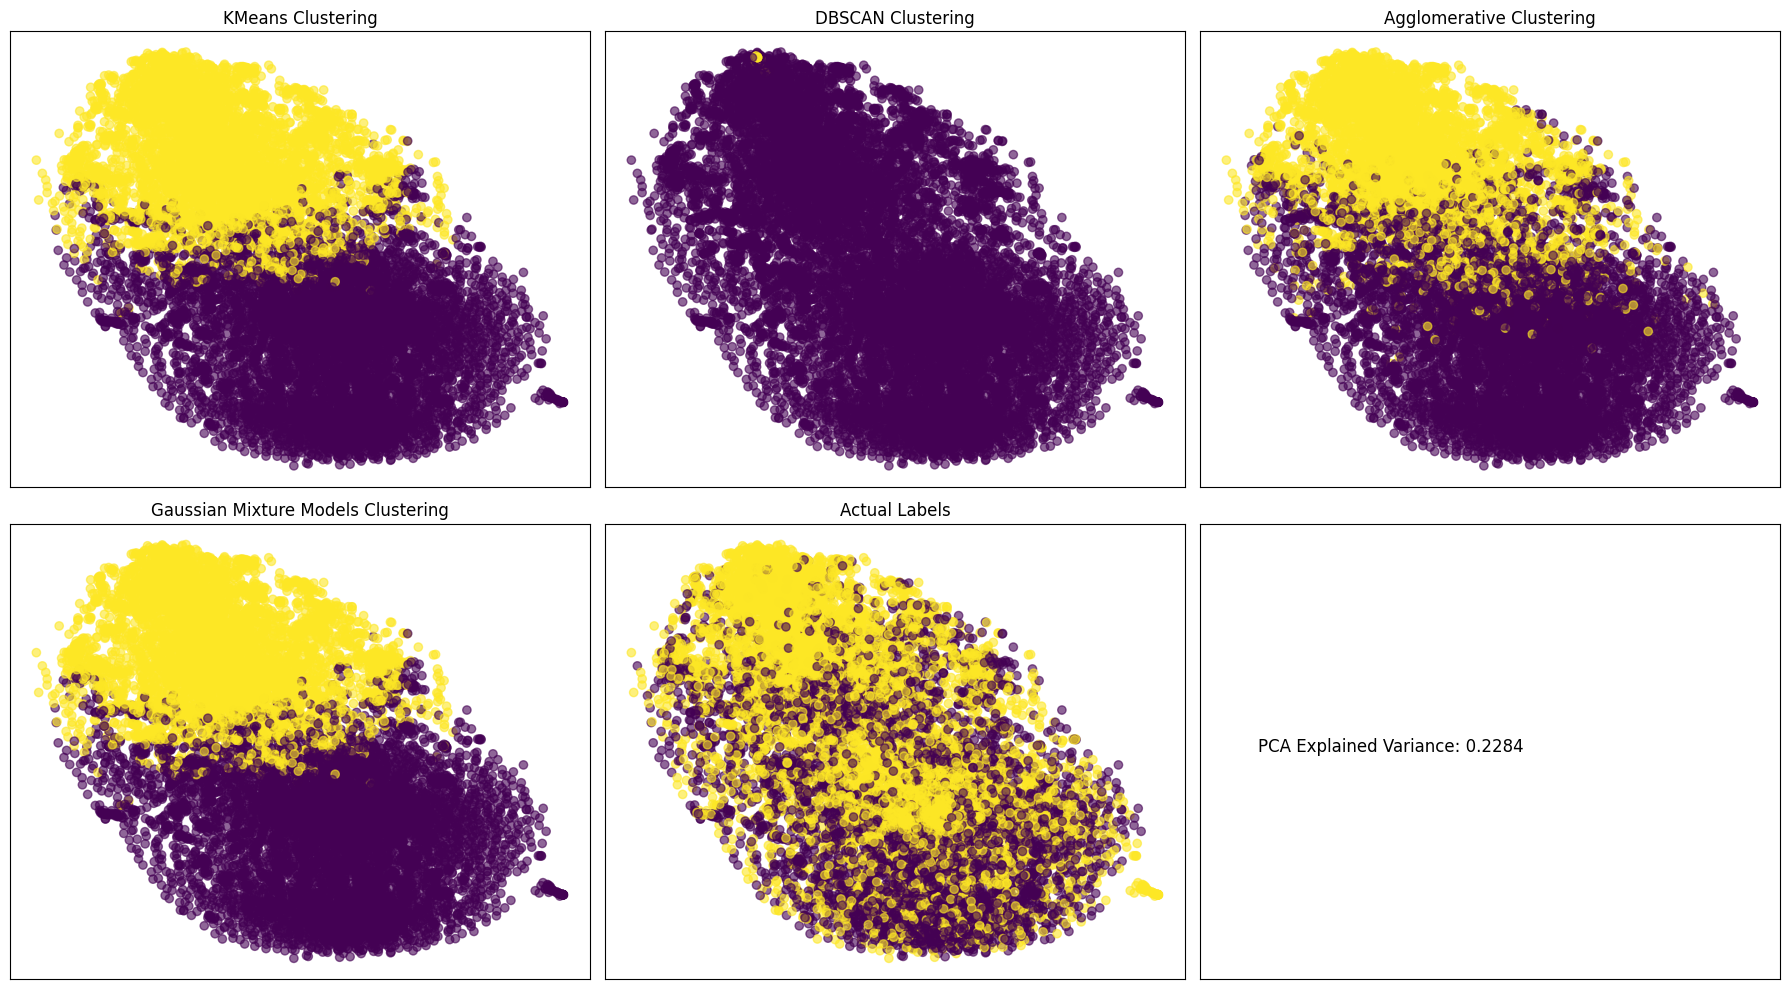

In [22]:
# Tạo biểu đồ
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plot_clustering(axes[0, 0], 'KMeans Clustering', tsne_result, kmeans_labels)
plot_clustering(axes[0, 1], 'DBSCAN Clustering', tsne_result, dbscan_labels)
plot_clustering(axes[0, 2], 'Agglomerative Clustering', tsne_result, agg_labels)
plot_clustering(axes[1, 0], 'Gaussian Mixture Models Clustering', tsne_result, gmm_labels)
plot_clustering(axes[1, 1], 'Actual Labels', tsne_result, np.argmax(train_labels, axis=1))
axes[1, 2].text(0.1, 0.5, f"PCA Explained Variance: {explained_variance:.4f}", fontsize=12)
axes[1, 2].set_xticks([])
axes[1, 2].set_yticks([])
plt.tight_layout()
plt.show()

# Lưu biểu đồ từ đối tượng Figure
fig.savefig('ten_file.png')

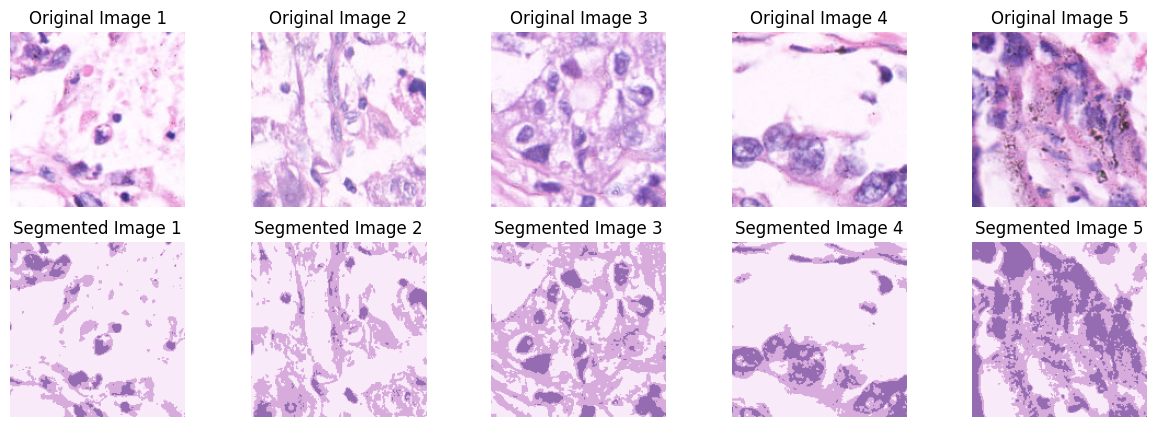

<Figure size 640x480 with 0 Axes>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import os

# Đường dẫn tới thư mục chứa ảnh training
train_dir = 'data/train/Abnormal'

# Chọn một số ảnh từ thư mục training
selected_images = []
num_images_to_use = 5  # Số lượng ảnh muốn sử dụng
for filename in os.listdir(train_dir)[:num_images_to_use]:
    img = Image.open(os.path.join(train_dir, filename))
    selected_images.append(np.array(img))

# Combine selected images into one numpy array
selected_images = np.array(selected_images)

# Reshape ảnh để phù hợp với đầu vào của KMeans
w, h, d = original_shape = tuple(selected_images.shape[1:])
assert d == 3
image_array = np.reshape(selected_images, (num_images_to_use * w * h, d))

# Áp dụng KMeans để phân cụm ảnh
n_colors = 3  # Số lượng cụm mong muốn
kmeans = KMeans(n_clusters=n_colors, random_state=0)
kmeans.fit(image_array)

# Dự đoán nhãn cho tất cả các điểm dữ liệu
labels = kmeans.predict(image_array)

# Tạo ảnh phân đoạn từ các nhãn
segmented_images = np.zeros((num_images_to_use, w, h, d))
label_idx = 0
for i in range(num_images_to_use):
    for j in range(w):
        for k in range(h):
            segmented_images[i, j, k] = kmeans.cluster_centers_[labels[label_idx]] / 255.0
            label_idx += 1

# Visualize các ảnh gốc và ảnh phân đoạn
plt.figure(figsize=(15, 5))
for i in range(num_images_to_use):
    plt.subplot(2, num_images_to_use, i + 1)
    plt.imshow(selected_images[i])
    plt.title('Original Image {}'.format(i+1))
    plt.axis('off')

    plt.subplot(2, num_images_to_use, i + 1 + num_images_to_use)
    plt.imshow(segmented_images[i])
    plt.title('Segmented Image {}'.format(i+1))
    plt.axis('off')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from PIL import Image
import os

# Đường dẫn tới thư mục chứa ảnh training
train_dir = 'data/train/Abnormal'

# Chọn một số ảnh từ thư mục training
selected_images = []
num_images_to_use = 1  # Số lượng ảnh muốn sử dụng
for filename in os.listdir(train_dir)[:num_images_to_use]:
    img = Image.open(os.path.join(train_dir, filename))
    # img = img.resize((img.width // 4, img.height // 4))
    selected_images.append(np.array(img))

# Combine selected images into one numpy array
selected_images = np.array(selected_images)

# Reshape ảnh để phù hợp với đầu vào của KMeans
w, h, d = original_shape = tuple(selected_images.shape[1:])
assert d == 3
image_array = np.reshape(selected_images, (num_images_to_use * w * h, d))

# KMeans
n_colors = 3  # Số lượng cụm mong muốn
kmeans = KMeans(n_clusters=n_colors, random_state=0)
kmeans.fit(image_array)
kmeans_labels = kmeans.predict(image_array)
kmeans_segmented_images = np.zeros((num_images_to_use, w, h, d))
label_idx = 0
for i in range(num_images_to_use):
    for j in range(w):
        for k in range(h):
            kmeans_segmented_images[i, j, k] = kmeans.cluster_centers_[kmeans_labels[label_idx]] / 255.0
            label_idx += 1

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(image_array)
dbscan_unique_labels = np.unique(dbscan_labels)
dbscan_centroids = np.array([image_array[dbscan_labels == label].mean(axis=0) for label in dbscan_unique_labels])
dbscan_segmented_images = np.zeros((num_images_to_use, w, h, d))
label_idx = 0
for i in range(num_images_to_use):
    for j in range(w):
        for k in range(h):
            if dbscan_labels[label_idx] != -1:  # Ignore noise points
                dbscan_segmented_images[i, j, k] = dbscan_centroids[dbscan_labels[label_idx]] / 255.0
            else:
                dbscan_segmented_images[i, j, k] = [0, 0, 0]  # Assign black color to noise points
            label_idx += 1

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=n_colors)
agg_labels = agg.fit_predict(image_array)
agg_segmented_images = np.zeros((num_images_to_use, w, h, d))
label_idx = 0
for i in range(num_images_to_use):
    for j in range(w):
        for k in range(h):
            agg_segmented_images[i, j, k] = kmeans.cluster_centers_[agg_labels[label_idx]] / 255.0  # Using KMeans centroids for color
            label_idx += 1

# Gaussian Mixture Models
gmm = GaussianMixture(n_components=n_colors, random_state=0)
gmm_labels = gmm.fit_predict(image_array)
gmm_segmented_images = np.zeros((num_images_to_use, w, h, d))
label_idx = 0
for i in range(num_images_to_use):
    for j in range(w):
        for k in range(h):
            gmm_segmented_images[i, j, k] = gmm.means_[gmm_labels[label_idx]] / 255.0
            label_idx += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.6304688550568897..1.000000000000021].


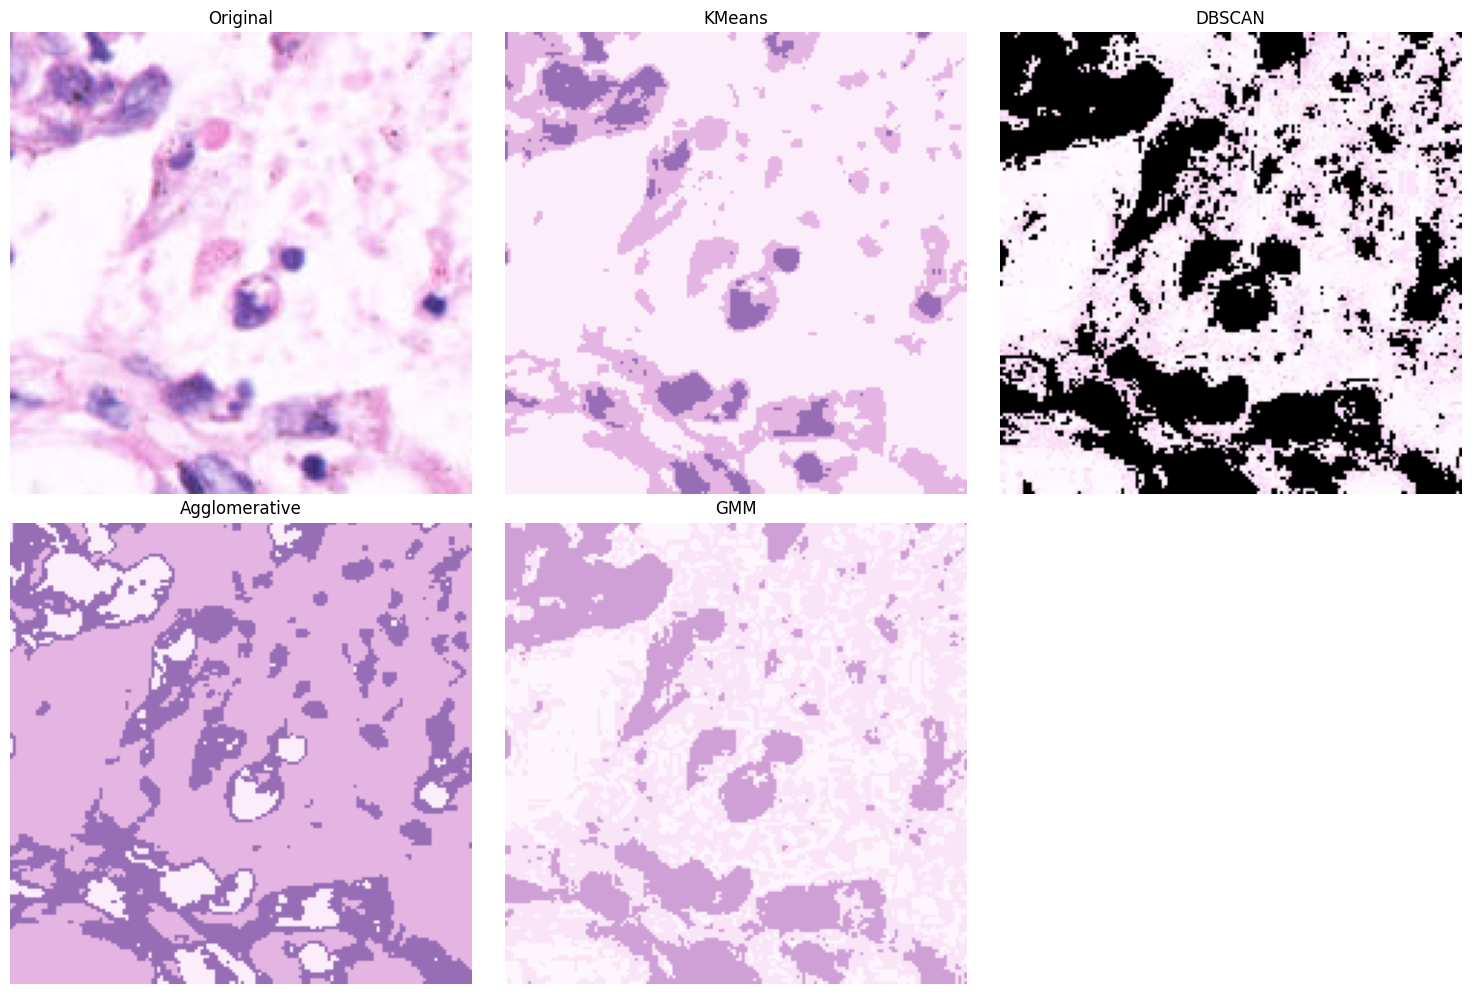

In [11]:
# Visualize các ảnh gốc và ảnh phân đoạn
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
algorithms = ['Original', 'KMeans', 'DBSCAN', 'Agglomerative', 'GMM']
segmented_images_list = [selected_images, kmeans_segmented_images, dbscan_segmented_images, agg_segmented_images, gmm_segmented_images]

for idx, (alg, segmented_images) in enumerate(zip(algorithms, segmented_images_list)):
    row = idx // 3
    col = idx % 3
    axes[row, col].imshow(segmented_images[0])  # Chỉ có một ảnh gốc
    axes[row, col].set_title(alg)
    axes[row, col].axis('off')

# Nếu có ô dư, ta sẽ tắt chúng đi
if len(algorithms) < 6:
    for idx in range(len(algorithms), 6):
        row = idx // 3
        col = idx % 3
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()